In [2]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm
import warnings
import json
warnings.filterwarnings('ignore')

# Paths
BASE_DIR = Path.cwd().parent.parent.parent
DATA_DIR = BASE_DIR / "oc_mini"

# Add hcat package to path
sys.path.insert(0, str(BASE_DIR / "cat-hcat" / "hcat"))

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Load tree and metadata
tree_path = DATA_DIR / "clustering" / "hierarchical" / "oc_mini_paris.json"
metadata_path = DATA_DIR / "metadata" / "oc_mini_node_metadata.csv"

with open(tree_path, 'r') as f:
    tree_data = json.load(f)

metadata_df = pd.read_csv(metadata_path)

print(f"Tree data loaded: {tree_data['num_nodes']} nodes")
print(f"Metadata loaded: {len(metadata_df)} entries")

# IMPORTANT: Create test split BEFORE training
# This ensures validation and test sets use the same nodes
from notebook_utils import create_test_split

results_dir = BASE_DIR / "cat-hcat" / "hcat" / "experiments" / "results"
all_node_ids = [str(node_id) for node_id in metadata_df['id'].values]
test_val_nodes = create_test_split(all_node_ids, test_ratio=0.1, seed=42)

print(f"\nTest/Val set: {len(test_val_nodes)} nodes ({len(test_val_nodes)/len(all_node_ids)*100:.1f}%)")
print(f"Train set: {len(all_node_ids) - len(test_val_nodes)} nodes")

with open(results_dir / "text_val_nodes.json", 'w') as f:
    json.dump(test_val_nodes, f, 
              default=lambda o: o.tolist() if isinstance(o, np.ndarray) else float(o) if isinstance(o, np.floating) else int(o) if isinstance(o, np.integer) else o)

metadata_df.head()

Tree data loaded: 14384 nodes
Metadata loaded: 14442 entries

Test/Val set: 1444 nodes (10.0%)
Train set: 12998 nodes


,id,doi,title,abstract
0,128,10.1101/2021.05.10.443415,Improved protein contact prediction using dime...,AbstractDeep residual learning has shown great...
1,163,10.1101/2021.05.07.443114,Following the Trail of One Million Genomes: Fo...,AbstractSevere acute respiratory syndrome coro...
2,200,10.1101/2021.05.11.443555,Mechanism of molnupiravir-induced SARS-CoV-2 m...,Molnupiravir is an orally available antiviral ...
3,941,10.3390/ijms20020449,Bactericidal and Cytotoxic Properties of Silve...,Silver nanoparticles (AgNPs) can be synthesize...
4,1141,10.3390/ijms20040865,Silver Nanoparticles: Synthesis and Applicatio...,"Over the past few decades, metal nanoparticles..."


In [15]:
from train import train_model

# Train model with adaptive margin triplet loss
# Using test_val_nodes for validation to ensure consistency
finetuned_model, tokenizer, history = train_model(
    tree_json_path=str(tree_path),
    metadata_csv_path=str(metadata_path),
    output_dir=str(BASE_DIR / "cat" / "models" / "finetuned_minilm_adaptive_margin"),
    model_name='sentence-transformers/all-MiniLM-L6-v2',
    device=str(device),
    batch_size=16,
    epochs=3,
    lr=2e-5,
    base_margin=0.5,        # Base triplet margin
    distance_scale=0.05,     # KEY: Scale margin by tree distance
    samples_per_leaf=3,     # ~43K triplets for 14K leaves
    pooling='cls',
    sampling_strategy='hierarchical',
    val_nodes=test_val_nodes,  # Use same nodes for validation as we'll use for testing
    loss_type='hybrid',
    triplet_weight=0.8,        # Weight for ranking component
    regression_weight=0.2,     # Weight for distance regression
)

Using device: cuda

Loading tree from /home/vikramr2/oc_mini/clustering/hierarchical/oc_mini_paris.json...
  Leaves: 14384
  Total nodes: 28767
  Max depth: 25

Loading metadata from /home/vikramr2/oc_mini/metadata/oc_mini_node_metadata.csv...
  Entries: 14442

Loading model: sentence-transformers/all-MiniLM-L6-v2...

Creating dataset...


Generating triplets: 100%|██████████| 14384/14384 [31:27<00:00,  7.62it/s]


  Generated 43152 triplets
  Using 1444 nodes for validation (node-level split)
  Train: 38835 triplets | Val: 4317 triplets
  Train nodes: 0 (approx)
  Val nodes: 1444

Configuring loss function...
  Auto-detected max_tree_distance: 25.0
Loss: HybridHierarchicalLoss
  Base margin: 0.5
  Distance scale: 0.05
  Max tree distance: 25.0
  Triplet weight: 0.8
  Regression weight: 0.2

Starting training for 3 epochs

Epoch 1/3
------------------------------------------------------------


Training: 100%|██████████| 2428/2428 [08:58<00:00,  4.51it/s, loss=0.0068]


  Train loss: 0.2470


Evaluating: 100%|██████████| 270/270 [00:29<00:00,  9.27it/s]


  Val loss: 0.0270
  ✓ New best! Saving to /home/vikramr2/cat/models/finetuned_minilm_adaptive_margin...

Epoch 2/3
------------------------------------------------------------


Training: 100%|██████████| 2428/2428 [08:59<00:00,  4.50it/s, loss=0.0004]


  Train loss: 0.0171


Evaluating: 100%|██████████| 270/270 [00:28<00:00,  9.40it/s]


  Val loss: 0.0093
  ✓ New best! Saving to /home/vikramr2/cat/models/finetuned_minilm_adaptive_margin...

Epoch 3/3
------------------------------------------------------------


Training: 100%|██████████| 2428/2428 [08:57<00:00,  4.52it/s, loss=0.0004]


  Train loss: 0.0110


Evaluating: 100%|██████████| 270/270 [00:29<00:00,  9.31it/s]


  Val loss: 0.0109

Training complete!
  Best val loss: 0.0093
  Model saved to: /home/vikramr2/cat/models/finetuned_minilm_adaptive_margin


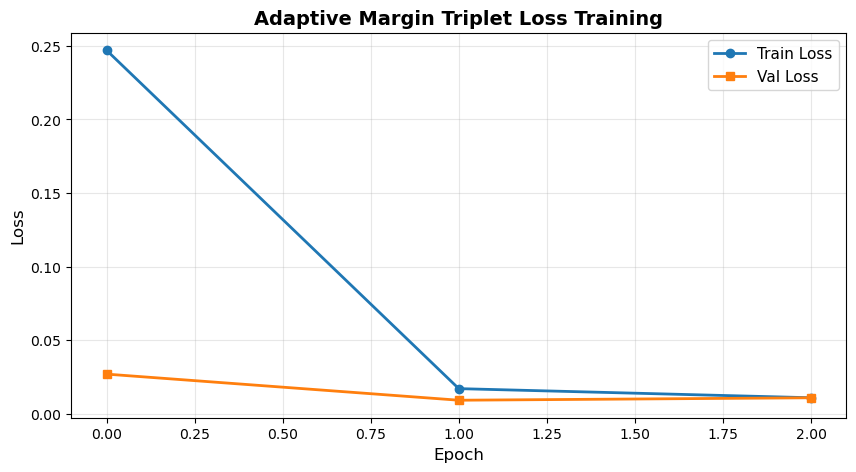


Final train loss: 0.0110
Final val loss: 0.0109


In [16]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], marker='o', label='Train Loss', linewidth=2)
plt.plot(history['val_loss'], marker='s', label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Adaptive Margin Triplet Loss Training', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal train loss: {history['train_loss'][-1]:.4f}")
print(f"Final val loss: {history['val_loss'][-1]:.4f}")

In [17]:
from notebook_utils import compute_embeddings

# Load the BEST saved model (not the final epoch model)
output_dir = BASE_DIR / "cat" / "models" / "finetuned_minilm_adaptive_margin"

print("Loading best saved model...")
best_tokenizer = AutoTokenizer.from_pretrained(str(output_dir))
best_model = AutoModel.from_pretrained(str(output_dir)).to(device)
best_model.eval()

print(f"✓ Loaded best model from: {output_dir}")

# Compute embeddings for all nodes using BEST model
print("\nComputing embeddings with best model...")
embeddings_dict = compute_embeddings(
    best_model,  # Use BEST saved model
    best_tokenizer,
    metadata_df,
    device,
    batch_size=32
)

print(f"✓ Computed embeddings for {len(embeddings_dict)} nodes")

Loading best saved model...
✓ Loaded best model from: /home/vikramr2/cat/models/finetuned_minilm_adaptive_margin

Computing embeddings with best model...
Preparing 14442 documents...


Preparing:   0%|          | 0/14442 [00:00<?, ?it/s]

Computing embeddings:   0%|          | 0/452 [00:00<?, ?it/s]

✓ Computed embeddings for 14442 nodes
✓ Computed embeddings for 14442 nodes


Evaluating on test set: 1444 nodes

NETWORK LINK PREDICTION EVALUATION

Loading edgelist from: /home/vikramr2/oc_mini/network/oc_mini_edgelist.csv
Loaded 111873 edges
Network has 14384 unique nodes
Test nodes with embeddings and edges: 1439

Evaluating link prediction with top-k retrieval...
Test nodes: 1439
K values: [5, 10, 20, 50, 100]


Evaluating nodes:   0%|          | 0/1439 [00:00<?, ?it/s]


Evaluating link prediction with AUC metrics...
Test nodes: 1439
Negative samples per positive: 10


Sampling edges:   0%|          | 0/1439 [00:00<?, ?it/s]


RESULTS SUMMARY

Top-K Metrics:
  K=5:
    Precision@5: 0.0256
    Recall@5: 0.0118
    Hit Rate@5: 0.1112
  K=10:
    Precision@10: 0.0220
    Recall@10: 0.0194
    Hit Rate@10: 0.1758
  K=20:
    Precision@20: 0.0185
    Recall@20: 0.0325
    Hit Rate@20: 0.2682
  K=50:
    Precision@50: 0.0141
    Recall@50: 0.0619
    Hit Rate@50: 0.4225
  K=100:
    Precision@100: 0.0114
    Recall@100: 0.0959
    Hit Rate@100: 0.5587

AUC Metrics:
  AUC-ROC: 0.7724
  AUC-PR: 0.2560



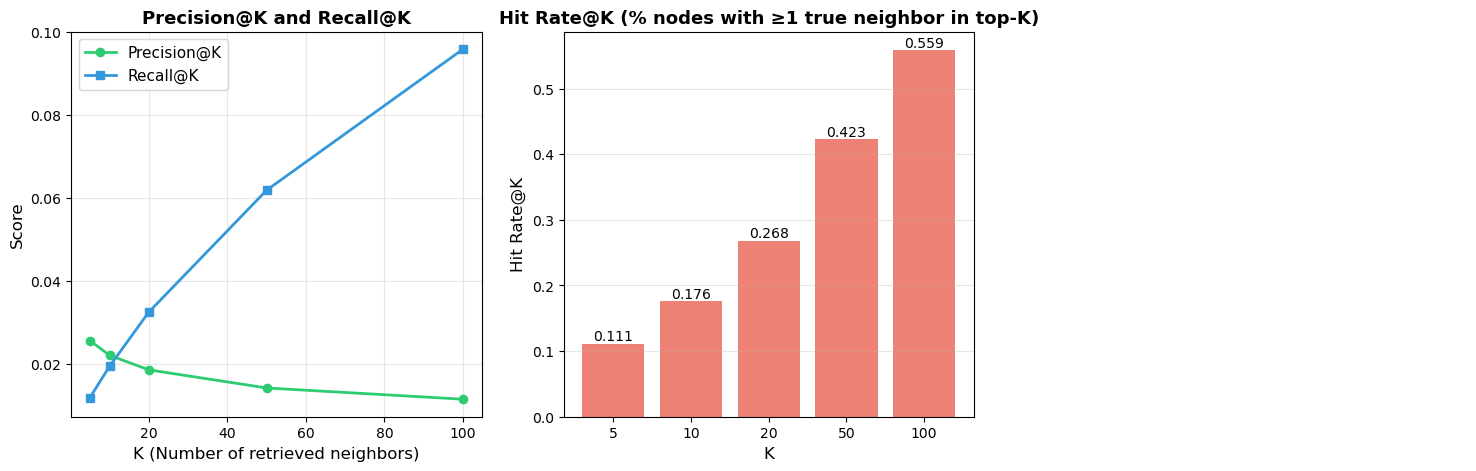

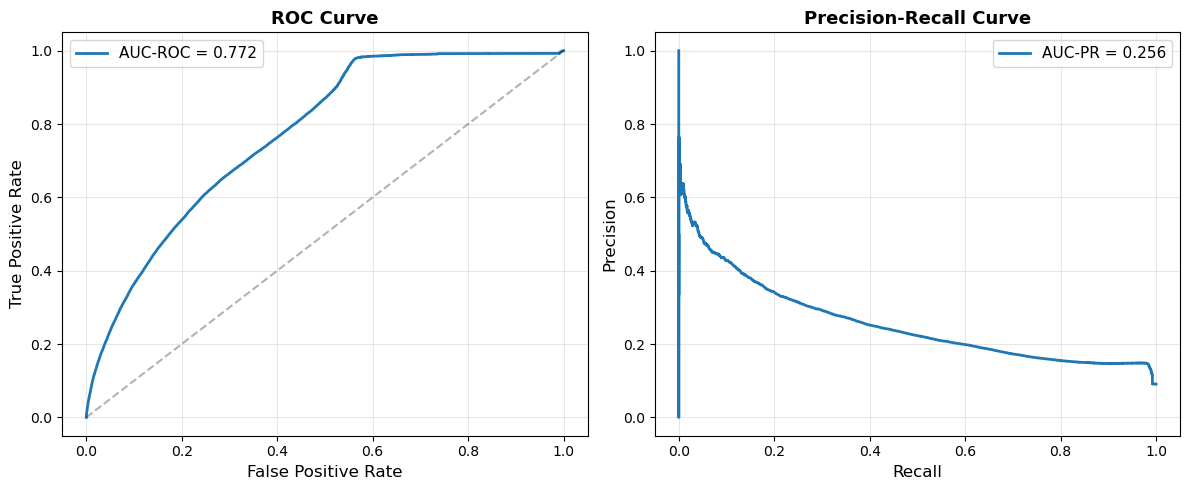

<Figure size 640x480 with 0 Axes>

In [18]:
# Import evaluation functions
sys.path.insert(0, str(BASE_DIR / "cat" / "experiments"))

from network_link_prediction import (
    evaluate_network_link_prediction,
    plot_link_prediction_results
)

edgelist_path = DATA_DIR / "network" / "oc_mini_edgelist.csv"

# Evaluate fine-tuned model using the SAME nodes as validation
print(f"Evaluating on test set: {len(test_val_nodes)} nodes")
results = evaluate_network_link_prediction(
    edgelist_path=str(edgelist_path),
    embeddings_dict=embeddings_dict,
    test_nodes=test_val_nodes,  # Same as validation nodes
    k_values=[5, 10, 20, 50, 100],
    compute_auc=True,
    num_negative_samples=10
)

# Visualize
plot_link_prediction_results(results['topk'], results['auc'])

In [19]:
# Load baseline MiniLM (not fine-tuned)
print("Loading baseline model...")
baseline_model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2").to(device)
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# Compute baseline embeddings
print("Computing baseline embeddings...")
baseline_embeddings = compute_embeddings(
    baseline_model,
    tokenizer,
    metadata_df,
    device,
    batch_size=32
)

print(f"✓ Baseline embeddings: {len(baseline_embeddings)} nodes")

Loading baseline model...
Computing baseline embeddings...
Preparing 14442 documents...


Preparing:   0%|          | 0/14442 [00:00<?, ?it/s]

Computing embeddings:   0%|          | 0/452 [00:00<?, ?it/s]

✓ Computed embeddings for 14442 nodes
✓ Baseline embeddings: 14442 nodes


In [20]:
# Evaluate baseline
print("Evaluating baseline...")
baseline_results = evaluate_network_link_prediction(
    edgelist_path=str(edgelist_path),
    embeddings_dict=baseline_embeddings,
    test_nodes=test_val_nodes,
    k_values=[5, 10, 20, 50, 100],
    compute_auc=True,
    num_negative_samples=10
)

Evaluating baseline...

NETWORK LINK PREDICTION EVALUATION

Loading edgelist from: /home/vikramr2/oc_mini/network/oc_mini_edgelist.csv
Loaded 111873 edges
Network has 14384 unique nodes
Test nodes with embeddings and edges: 1439

Evaluating link prediction with top-k retrieval...
Test nodes: 1439
K values: [5, 10, 20, 50, 100]


Evaluating nodes:   0%|          | 0/1439 [00:00<?, ?it/s]


Evaluating link prediction with AUC metrics...
Test nodes: 1439
Negative samples per positive: 10


Sampling edges:   0%|          | 0/1439 [00:00<?, ?it/s]


RESULTS SUMMARY

Top-K Metrics:
  K=5:
    Precision@5: 0.0873
    Recall@5: 0.0429
    Hit Rate@5: 0.3238
  K=10:
    Precision@10: 0.0687
    Recall@10: 0.0639
    Hit Rate@10: 0.4343
  K=20:
    Precision@20: 0.0529
    Recall@20: 0.0960
    Hit Rate@20: 0.5386
  K=50:
    Precision@50: 0.0367
    Recall@50: 0.1617
    Hit Rate@50: 0.6873
  K=100:
    Precision@100: 0.0267
    Recall@100: 0.2253
    Hit Rate@100: 0.7915

AUC Metrics:
  AUC-ROC: 0.8111
  AUC-PR: 0.3255




PRECISION@K COMPARISON: Baseline vs Fine-tuned (Adaptive Margin Loss)
  K  Baseline Precision  Fine-tuned Precision  Improvement  Improvement %
  5            0.087283              0.025573    -0.061710     -70.700637
 10            0.068659              0.022029    -0.046630     -67.914980
 20            0.052919              0.018520    -0.034399     -65.003283
 50            0.036664              0.014149    -0.022516     -61.410159
100            0.026671              0.011432    -0.015240     -57.139135

AUC METRICS
Baseline AUC-ROC:    0.8111
Fine-tuned AUC-ROC:  0.7724
Improvement:         -0.0387 (-4.8%)

Baseline AUC-PR:     0.3255
Fine-tuned AUC-PR:   0.2560
Improvement:         -0.0695 (-21.4%)


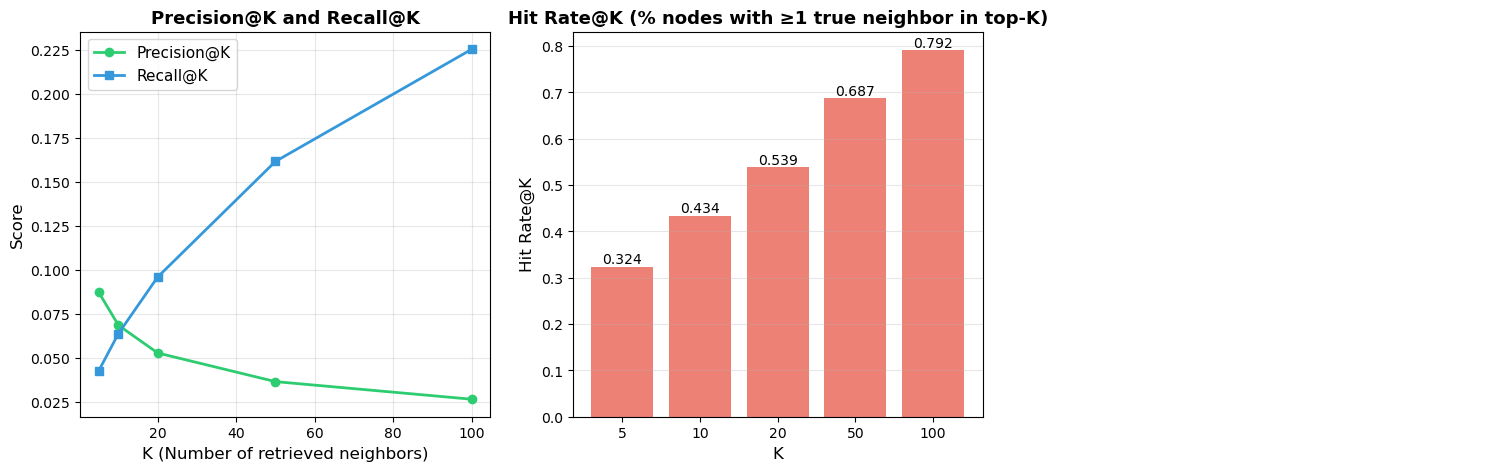

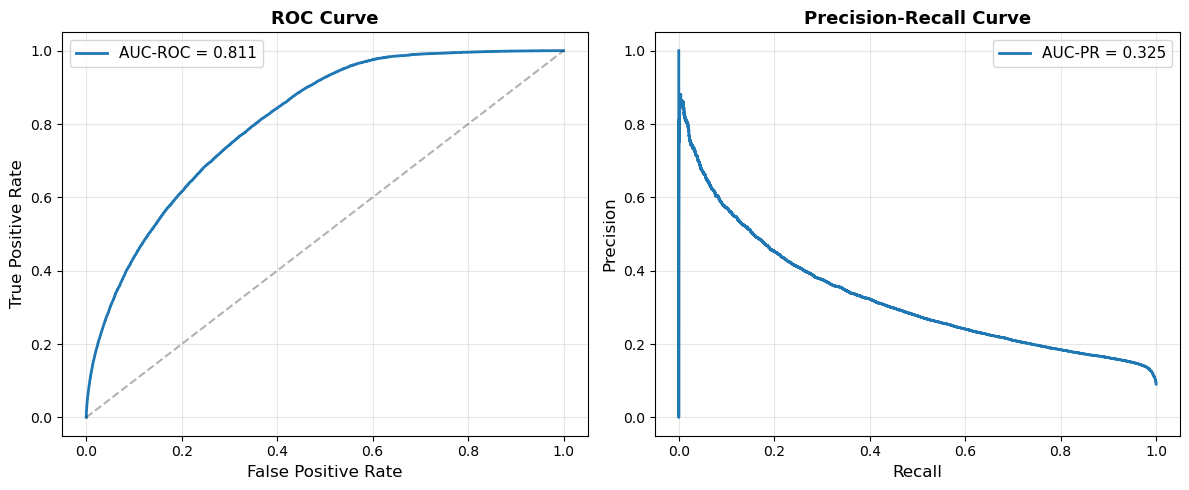

<Figure size 640x480 with 0 Axes>

In [21]:
# Create comparison table
k_values = [5, 10, 20, 50, 100]
comparison_data = []

for k in k_values:
    baseline_prec = baseline_results['topk']['summary'][k]['precision@k']
    finetuned_prec = results['topk']['summary'][k]['precision@k']

    comparison_data.append({
        'K': k,
        'Baseline Precision': baseline_prec,
        'Fine-tuned Precision': finetuned_prec,
        'Improvement': finetuned_prec - baseline_prec,
        'Improvement %': ((finetuned_prec - baseline_prec) / baseline_prec) * 100
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("PRECISION@K COMPARISON: Baseline vs Fine-tuned (Adaptive Margin Loss)")
print("="*80)
print(comparison_df.to_string(index=False))

# AUC comparison
print("\n" + "="*80)
print("AUC METRICS")
print("="*80)
print(f"Baseline AUC-ROC:    {baseline_results['auc']['auc_roc']:.4f}")
print(f"Fine-tuned AUC-ROC:  {results['auc']['auc_roc']:.4f}")
print(f"Improvement:         {results['auc']['auc_roc'] - baseline_results['auc']['auc_roc']:.4f} " +
      f"({((results['auc']['auc_roc'] - baseline_results['auc']['auc_roc'])/baseline_results['auc']['auc_roc'])*100:.1f}%)")
print()
print(f"Baseline AUC-PR:     {baseline_results['auc']['auc_pr']:.4f}")
print(f"Fine-tuned AUC-PR:   {results['auc']['auc_pr']:.4f}")
print(f"Improvement:         {results['auc']['auc_pr'] - baseline_results['auc']['auc_pr']:.4f} " +
      f"({((results['auc']['auc_pr'] - baseline_results['auc']['auc_pr'])/baseline_results['auc']['auc_pr'])*100:.1f}%)")

# Visualize
plot_link_prediction_results(baseline_results['topk'], baseline_results['auc'])

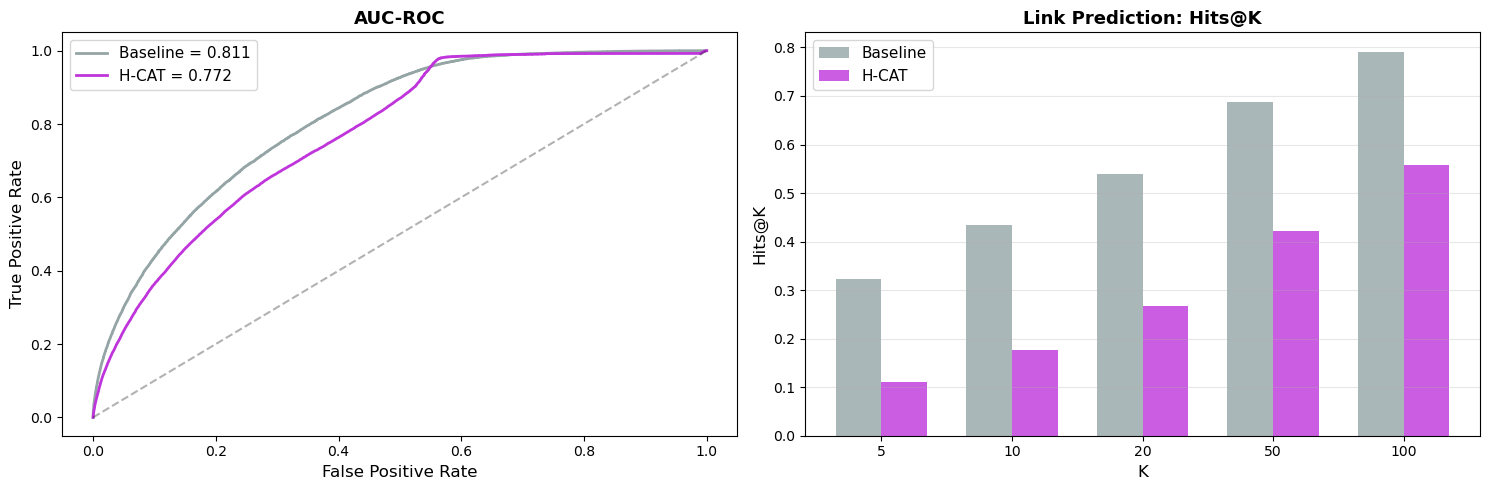

In [22]:
from sklearn.metrics import roc_curve

# Side-by-side comparison plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# AUC-ROC
ax = axes[0]

fpr, tpr, _ = roc_curve(results['auc']['y_true'], results['auc']['y_scores'])
baseline_fpr, baseline_tpr, _ = roc_curve(results['auc']['y_true'], baseline_results['auc']['y_scores'])

ax.plot(baseline_fpr, baseline_tpr, linewidth=2, label=f"Baseline = {baseline_results['auc']['auc_roc']:.3f}", color='#95a5a6')
ax.plot(fpr, tpr, linewidth=2, label=f"H-CAT = {results['auc']['auc_roc']:.3f}", color='#bf34db')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('AUC-ROC', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)

# Hit Rate @ K
ax = axes[1]
x = np.arange(len(k_values))
width = 0.35

baseline_prec = [baseline_results['topk']['summary'][k]['hit_rate@k'] for k in k_values]
finetuned_prec = [results['topk']['summary'][k]['hit_rate@k'] for k in k_values]

bars1 = ax.bar(x - width/2, baseline_prec, width, label='Baseline', alpha=0.8, color='#95a5a6')
bars2 = ax.bar(x + width/2, finetuned_prec, width, label='H-CAT', alpha=0.8, color='#bf34db')

ax.set_xlabel('K', fontsize=12)
ax.set_ylabel('Hits@K', fontsize=12)
ax.set_title('Link Prediction: Hits@K', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(k_values)
ax.legend(fontsize=11)
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
# Import evaluation functions
sys.path.insert(0, str(BASE_DIR / "cat-hcat"))

from hcat.tree_utils import HierarchicalTree
from utils.evaluation.tree_eval import evaluate_tree_structure

# Load your tree
tree = HierarchicalTree(tree_data)

In [24]:
# Evaluate baseline embeddings with your test set
baseline_tree_results = evaluate_tree_structure(
    tree=tree,
    embeddings_dict=baseline_embeddings,
    test_nodes=test_val_nodes,  # Your test set!
    depth_levels=[2, 3, 4, 5],
    distance_sample_size=2000,
    random_state=42
)


               TREE STRUCTURE EVALUATION

SUBTREE CLASSIFICATION EVALUATION
Evaluating at depths: [2, 3, 4, 5]
Cross-validation folds: 5
Evaluating 1439 test nodes

--- Depth 2 ---
  Subtrees: 4
  Samples: 1439
  Accuracy: 0.9653 ± 0.0049
  Random baseline: 0.6787
  Lift over random: 1.42x

--- Depth 3 ---
  Subtrees: 8
  Samples: 1439
  Accuracy: 0.9326 ± 0.0086
  Random baseline: 0.4904
  Lift over random: 1.90x

--- Depth 4 ---
  Skipping: smallest class has only 1 sample(s)

--- Depth 5 ---
  Skipping: smallest class has only 1 sample(s)

TREE DISTANCE CORRELATION EVALUATION
Evaluating 1439 test nodes
Sampling 2000 pairs...


Computing distances:   0%|          | 0/2000 [00:00<?, ?it/s]


Spearman correlation: 0.3401 (p=2.35e-55)
Number of pairs evaluated: 2000

Mean embedding distance by tree distance:
  Tree dist 9: 0.1373 ± 0.0440 (14 pairs)
  Tree dist 10: 0.1312 ± 0.0476 (29 pairs)
  Tree dist 11: 0.1211 ± 0.0340 (39 pairs)
  Tree dist 12: 0.1365 ± 0.0588 (82 pairs)
  Tree dist 13: 0.1473 ± 0.0649 (127 pairs)

SUMMARY

Subtree Classification:
  Depth 2: 0.9653 (baseline: 0.6787, 4 classes)
  Depth 3: 0.9326 (baseline: 0.4904, 8 classes)

Tree Distance Correlation:
  Spearman ρ: 0.3401



In [25]:
finetuned_tree_results = evaluate_tree_structure(
    tree=tree,
    embeddings_dict=embeddings_dict,
    test_nodes=test_val_nodes,  # Same test set
    depth_levels=[2, 3, 4, 5],
    distance_sample_size=2000,
    random_state=42
)


               TREE STRUCTURE EVALUATION

SUBTREE CLASSIFICATION EVALUATION
Evaluating at depths: [2, 3, 4, 5]
Cross-validation folds: 5
Evaluating 1439 test nodes

--- Depth 2 ---
  Subtrees: 4
  Samples: 1439
  Accuracy: 0.9138 ± 0.0025
  Random baseline: 0.6787
  Lift over random: 1.35x

--- Depth 3 ---
  Subtrees: 8
  Samples: 1439
  Accuracy: 0.8867 ± 0.0113
  Random baseline: 0.4904
  Lift over random: 1.81x

--- Depth 4 ---
  Skipping: smallest class has only 1 sample(s)

--- Depth 5 ---
  Skipping: smallest class has only 1 sample(s)

TREE DISTANCE CORRELATION EVALUATION
Evaluating 1439 test nodes
Sampling 2000 pairs...


Computing distances:   0%|          | 0/2000 [00:00<?, ?it/s]


Spearman correlation: 0.4559 (p=3.14e-103)
Number of pairs evaluated: 2000

Mean embedding distance by tree distance:
  Tree dist 9: 0.0920 ± 0.3310 (14 pairs)
  Tree dist 10: 0.0008 ± 0.0034 (29 pairs)
  Tree dist 11: 0.0003 ± 0.0008 (39 pairs)
  Tree dist 12: 0.0877 ± 0.3388 (82 pairs)
  Tree dist 13: 0.1120 ± 0.3576 (127 pairs)

SUMMARY

Subtree Classification:
  Depth 2: 0.9138 (baseline: 0.6787, 4 classes)
  Depth 3: 0.8867 (baseline: 0.4904, 8 classes)

Tree Distance Correlation:
  Spearman ρ: 0.4559



In [26]:
content_dict = (
    metadata_df.apply(
        lambda row: f"{row['title']} {row['abstract']}".strip() 
        if pd.notna(row['title']) or pd.notna(row['abstract']) 
        else '',
        axis=1
    )
    .to_dict()
)

content_dict = {str(k): v for k, v in content_dict.items()}

In [27]:
# First, check what columns you have:
print(metadata_df.columns)

# Then create text_dict using the correct ID column
# Replace 'paper_id' or 'id' with your actual column name
text_dict = {}
for _, row in metadata_df.iterrows():
    node_id = str(row['id'])  # or row['id'], row['node_id'], etc.
    title = str(row['title']) if pd.notna(row['title']) else ''
    abstract = str(row['abstract']) if pd.notna(row['abstract']) else ''
    
    combined_text = f"{title} {abstract}".strip()
    if combined_text:
        text_dict[node_id] = combined_text

print(f"Created text dictionary with {len(text_dict)} entries")

# Verify overlap
overlap = set(embeddings_dict.keys()) & set(text_dict.keys())
print(f"Overlap: {len(overlap)} keys in common")

Index(['id', 'doi', 'title', 'abstract'], dtype='object')
Created text dictionary with 14442 entries
Overlap: 14442 keys in common


In [28]:
# Import evaluation functions
sys.path.insert(0, str(BASE_DIR / "cat-hcat"))

from utils.evaluation.content_eval import evaluate_content_preservation

content_results = evaluate_content_preservation(
    embeddings_dict=embeddings_dict,
    baseline_embeddings_dict=baseline_embeddings,  # node_id -> embedding vector
    content_dict=text_dict,           # node_id -> text content
    test_nodes=test_val_nodes,          # your test nodes
    sample_size=2000,
    random_state=42
)


               CONTENT PRESERVATION EVALUATION

Evaluating fine-tuned embeddings...

EMBEDDING-BM25 CORRELATION EVALUATION
Evaluating 1444 nodes with both embeddings and content
Tokenizing documents...


Tokenizing:   0%|          | 0/1444 [00:00<?, ?it/s]

Building BM25 index...
Sampling 2000 pairs...
Computing similarities...


Computing pairs:   0%|          | 0/2000 [00:00<?, ?it/s]


Spearman correlation: 0.2086 (p=4.27e-21)
Pearson correlation: 0.1414 (p=2.15e-10)
Number of pairs evaluated: 2000

Mean embedding similarity by BM25 score quantile:
  Q0-25: emb_sim=0.4674 ± 0.6711, bm25=[0.00, 127.82] (500 pairs)
  Q25-50: emb_sim=0.4875 ± 0.6614, bm25=[127.82, 158.69] (500 pairs)
  Q50-75: emb_sim=0.5670 ± 0.6336, bm25=[158.69, 195.80] (500 pairs)
  Q75-90: emb_sim=0.6469 ± 0.6052, bm25=[195.80, 235.78] (300 pairs)
  Q90-95: emb_sim=0.6490 ± 0.6024, bm25=[235.78, 263.14] (100 pairs)
  Q95-100: emb_sim=0.8984 ± 0.3646, bm25=[263.14, 514.49] (100 pairs)

Evaluating baseline embeddings...

EMBEDDING-BM25 CORRELATION EVALUATION
Evaluating 1444 nodes with both embeddings and content
Tokenizing documents...


Tokenizing:   0%|          | 0/1444 [00:00<?, ?it/s]

Building BM25 index...
Sampling 2000 pairs...
Computing similarities...


Computing pairs:   0%|          | 0/2000 [00:00<?, ?it/s]


Spearman correlation: 0.3585 (p=1.02e-61)
Pearson correlation: 0.3556 (p=1.09e-60)
Number of pairs evaluated: 2000

Mean embedding similarity by BM25 score quantile:
  Q0-25: emb_sim=0.7828 ± 0.0743, bm25=[0.00, 127.82] (500 pairs)
  Q25-50: emb_sim=0.7986 ± 0.0731, bm25=[127.82, 158.69] (500 pairs)
  Q50-75: emb_sim=0.8195 ± 0.0704, bm25=[158.69, 195.80] (500 pairs)
  Q75-90: emb_sim=0.8398 ± 0.0687, bm25=[195.80, 235.78] (300 pairs)
  Q90-95: emb_sim=0.8503 ± 0.0669, bm25=[235.78, 263.14] (100 pairs)
  Q95-100: emb_sim=0.8846 ± 0.0489, bm25=[263.14, 514.49] (100 pairs)

SUMMARY

Fine-tuned Model BM25 Correlation:
  Spearman ρ: 0.2086
  Pearson r: 0.1414
  Nodes evaluated: 1444
  Pairs sampled: 2000

Baseline Model BM25 Correlation:
  Spearman ρ: 0.3585
  Pearson r: 0.3556
  Nodes evaluated: 1444
  Pairs sampled: 2000

Difference (Fine-tuned - Baseline):
  Δ Spearman ρ: -0.1499
  Δ Pearson r: -0.2143



In [30]:
from utils.evaluation.graph_dist_eval import evaluate_distance_correlation, plot_distance_correlation

edgelist_path = DATA_DIR / "network" / "oc_mini_edgelist.csv"

# Just like link_prediction.py
finetuned_distance_evaluation = evaluate_distance_correlation(
    edgelist_path=edgelist_path,
    embeddings_dict=embeddings_dict,
    test_nodes=test_val_nodes,  # List of node IDs to evaluate
    num_samples_per_node=100,     # Sample 100 pairs per test node
    max_graph_distance=10,
    embedding_distance_metric='cosine',
    sampling_strategy='stratified'  # or 'random'
)


GRAPH DISTANCE CORRELATION EVALUATION

Loading edgelist from: /home/vikramr2/oc_mini/network/oc_mini_edgelist.csv
Loaded 111873 edges
Building NetworkKit graph...
Graph has 14384 nodes and 111873 edges
Test nodes with embeddings and in graph: 1439

Sampling node pairs (strategy: stratified)...
Sampling from 1439 test nodes...


Stratified sampling:   0%|          | 0/1439 [00:00<?, ?it/s]

Sampled 132074 pairs

Computing shortest path distances...


Computing shortest paths:   0%|          | 0/1439 [00:00<?, ?it/s]

Pairs with finite graph distance: 132074

Computing embedding distances (metric: cosine)...

Final pair count: 132074

Computing correlations...

RESULTS SUMMARY

Correlation Metrics:
  Spearman correlation: 0.7235 (p=0.0000e+00)
  Pearson correlation: 0.7621 (p=0.0000e+00)

Distance Distribution:
  Distance 1: 11807 pairs, mean emb dist = 0.0129 ± 0.1381
  Distance 2: 14567 pairs, mean emb dist = 0.0224 ± 0.1823
  Distance 3: 14619 pairs, mean emb dist = 0.0299 ± 0.2044
  Distance 4: 14619 pairs, mean emb dist = 0.0893 ± 0.3349
  Distance 5: 14619 pairs, mean emb dist = 0.5723 ± 0.6791
  Distance 6: 14619 pairs, mean emb dist = 1.1478 ± 0.5132
  Distance 7: 14619 pairs, mean emb dist = 1.2931 ± 0.3209
  Distance 8: 14537 pairs, mean emb dist = 1.2731 ± 0.3556
  Distance 9: 12988 pairs, mean emb dist = 1.2494 ± 0.3787
  Distance 10: 5080 pairs, mean emb dist = 1.2072 ± 0.3381



In [32]:
# Just like link_prediction.py
baseline_distance_evaluation = evaluate_distance_correlation(
    edgelist_path=edgelist_path,
    embeddings_dict=baseline_embeddings,
    test_nodes=test_val_nodes,  # List of node IDs to evaluate
    num_samples_per_node=100,     # Sample 100 pairs per test node
    max_graph_distance=10,
    embedding_distance_metric='cosine',
    sampling_strategy='stratified'  # or 'random'
)


GRAPH DISTANCE CORRELATION EVALUATION

Loading edgelist from: /home/vikramr2/oc_mini/network/oc_mini_edgelist.csv
Loaded 111873 edges
Building NetworkKit graph...
Graph has 14384 nodes and 111873 edges
Test nodes with embeddings and in graph: 1439

Sampling node pairs (strategy: stratified)...
Sampling from 1439 test nodes...


Stratified sampling:   0%|          | 0/1439 [00:00<?, ?it/s]

Sampled 132074 pairs

Computing shortest path distances...


Computing shortest paths:   0%|          | 0/1439 [00:00<?, ?it/s]

Pairs with finite graph distance: 132074

Computing embedding distances (metric: cosine)...

Final pair count: 132074

Computing correlations...

RESULTS SUMMARY

Correlation Metrics:
  Spearman correlation: 0.7725 (p=0.0000e+00)
  Pearson correlation: 0.7752 (p=0.0000e+00)

Distance Distribution:
  Distance 1: 11807 pairs, mean emb dist = 0.1009 ± 0.0404
  Distance 2: 14567 pairs, mean emb dist = 0.1183 ± 0.0423
  Distance 3: 14619 pairs, mean emb dist = 0.1329 ± 0.0468
  Distance 4: 14619 pairs, mean emb dist = 0.1650 ± 0.0609
  Distance 5: 14619 pairs, mean emb dist = 0.2212 ± 0.0584
  Distance 6: 14619 pairs, mean emb dist = 0.2493 ± 0.0451
  Distance 7: 14619 pairs, mean emb dist = 0.2619 ± 0.0423
  Distance 8: 14537 pairs, mean emb dist = 0.2693 ± 0.0408
  Distance 9: 12988 pairs, mean emb dist = 0.2715 ± 0.0416
  Distance 10: 5080 pairs, mean emb dist = 0.2712 ± 0.0401

